# Improving neural network performance Part 3 - Transfer learning and fine-tuning

In [ ]:
# Library om YouTube videos te importeren 

from IPython.display import YouTubeVideo, Image

## 1 What is transfer learning?

### 1.1 Definitions

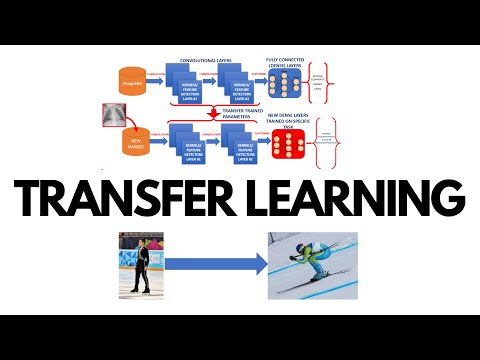

In [ ]:
YouTubeVideo("3gyeDlZqWko", width=800, height=500)

"Transfer learning" is a technique used in the training of neural networks, where a **pre-trained model** is adapted or fine-tuned to perform a new task. The idea is to leverage the knowledge learned from a previously solved problem or dataset, which often contains general features and patterns, and apply it to a different, but related problem or dataset. The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

Transfer learning is particularly useful in situations where the new task has limited labeled data or computational resources. By starting with a pre-trained model, the training process for the new task can be more efficient and require less data, as the neural network has already learned some useful features from the initial training.

The process of transfer learning typically involves the following steps:

1. **Selecting a pre-trained model:** The model should be trained on a similar task or a large dataset, such as ImageNet for computer vision tasks or GPT for natural language processing tasks.

2. **Removing the last layer(s):** The final layer(s) of the pre-trained model, which is usually task-specific, is removed to make the model more adaptable to the new task.

3. **Adding new layers:** New layers are added to the modified pre-trained model, which will be trained to perform the new task.

4. **Fine-tuning the model:** The modified model is then trained on the new task's dataset, either by training the newly added layers only, or by training the entire model with a smaller learning rate to prevent overwriting the previously learned features.

Transfer learning has been widely used in various deep learning applications, such as image classification, object detection, natural language processing, and more. It has proven to be an effective way to achieve high performance with less data and computational resources. Transfer learning has been used in several notable applications, such as [detection and classification of skin cancer better than any human dermatologist](https://www.nature.com/articles/nature21056).

### 1.2 Which models to use for transfer learning?

There are numerous pre-trained models available for transfer learning, depending on the specific domain and task you are working on. Here, we will list some popular models for common domains:

1. Computer Vision:

* VGG (VGG16, VGG19): Developed by the Visual Geometry Group at Oxford University, these models have shown great performance in image classification and object recognition tasks.

* ResNet (ResNet-18, ResNet-34, ResNet-50, ResNet-101, ResNet-152): These deep residual networks, introduced by Microsoft Research, have achieved state-of-the-art performance in image classification and have been widely used for various computer vision tasks.

* Inception (Inception-v3, Inception-v4): Developed by researchers at Google, these models have demonstrated strong performance in image classification and object detection tasks.

* EfficientNet: A family of models designed by Google Research that scale in a more efficient way compared to previous architectures, resulting in better performance with fewer parameters and less computational cost.

2. Natural Language Processing:

* BERT (Bidirectional Encoder Representations from Transformers): Developed by Google, BERT has been a breakthrough in the NLP field and has set new performance standards for various NLP tasks, such as sentiment analysis, named entity recognition, and question answering.

* GPT (Generative Pre-trained Transformer): A series of models developed by OpenAI, with GPT-3 being the most recent and powerful version (as of knowledge cutoff in September 2021). GPT models have achieved impressive results in a wide range of NLP tasks, including text generation, translation, summarization, and more.

* RoBERTa: A robustly optimized BERT model developed by Facebook AI that has demonstrated improved performance over the original BERT.

* DistilBERT: A smaller, distilled version of BERT developed by Hugging Face that maintains most of the performance while being faster and requiring fewer resources.

3. Speech Recognition:

* DeepSpeech: Developed by Mozilla, DeepSpeech is an open-source speech recognition model that can be used for transfer learning in various speech-to-text tasks.

4. Multi-modal (Combining vision and language):

* CLIP (Contrastive Language-Image Pre-training): Developed by OpenAI, CLIP is a multi-modal pre-trained model that can be fine-tuned for tasks involving both images and text, such as image captioning or visual question answering.

These are just a few examples of the many pre-trained models available for transfer learning. When choosing a model, consider factors such as the size of the model, its performance on similar tasks, and the computational resources available for training and inference.

Many deep learning libraries, such as TensorFlow, PyTorch, and Hugging Face Transformers, provide pre-trained models and tools to help you adapt them for your specific tasks. When working with Keras and TensorFlow, there are two built-in methods of accessing pre-trained models - the [Keras applications module](https://www.tensorflow.org/api_docs/python/tf/keras/applications) and the [TensorFlow Hub](https://www.tensorflow.org/hub).

## 2 Transfer learning tutorial

The remainder of this notebook has been adapted from this [tutorial](https://www.tensorflow.org/tutorials/images/transfer_learning) on the TensorFlow tutorials website.

In this tutorial, you will learn how to classify images of cats and dogs by using transfer learning from a pre-trained network.

In this notebook, you will try two ways to customize a pretrained model:

1. **Feature Extraction:** Use the representations learned by a previous network to extract meaningful features from new samples. You simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.

 You do not need to (re)train the entire model. The base convolutional network already contains features that are generically useful for classifying pictures. However, the final, classification part of the pretrained model is specific to the original classification task, and subsequently specific to the set of classes on which the model was trained.

2. **Fine-Tuning:** Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

You will follow the general machine learning workflow.

1. Examine and understand the data
1. Build an input pipeline, in this case using Keras ImageDataGenerator
1. Compose the model
   * Load in the pretrained base model (and pretrained weights)
   * Stack the classification layers on top
1. Train the model
1. Evaluate model


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

### 2.1 Data preprocessing

#### 2.1.1 Data download

In this tutorial, you will use a dataset containing several thousand images of cats and dogs. Download and extract a zip file containing the images, then create a `tf.data.Dataset` for training and validation using the `tf.keras.utils.image_dataset_from_directory` utility. You can learn more about loading images in this [tutorial](https://www.tensorflow.org/tutorials/load_data/images).

In [ ]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

68606236/68606236 [==============================] - 1s 0us/step
Found 2000 files belonging to 2 classes.


In [ ]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


Show the first nine images and labels from the training set:

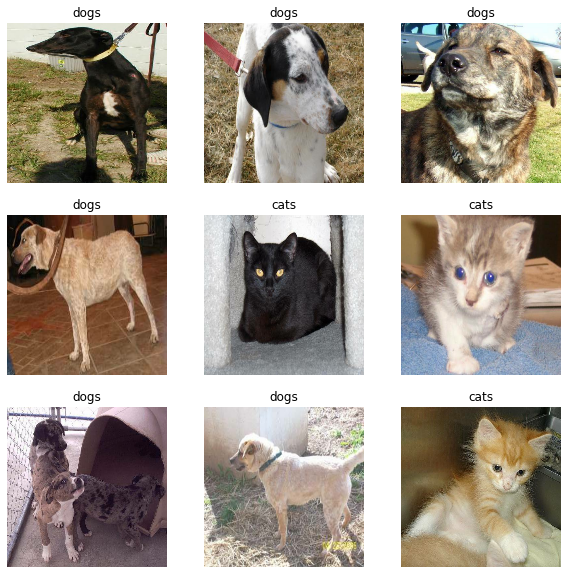

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

As the original dataset doesn't contain a test set, you will create one. To do so, determine how many batches of data are available in the validation set using `tf.data.experimental.cardinality`, then move 20% of them to a test set.

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


### 2.2 Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the [data performance](https://www.tensorflow.org/guide/data_performance) guide.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### 2.3 Use data augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit). You can learn more about data augmentation in this [tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation).

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Note: These layers are active only during training, when you call `Model.fit`. They are inactive when the model is used in inference mode in `Model.evaluate` or `Model.fit`.

Let's repeatedly apply these layers to the same image and see the result.

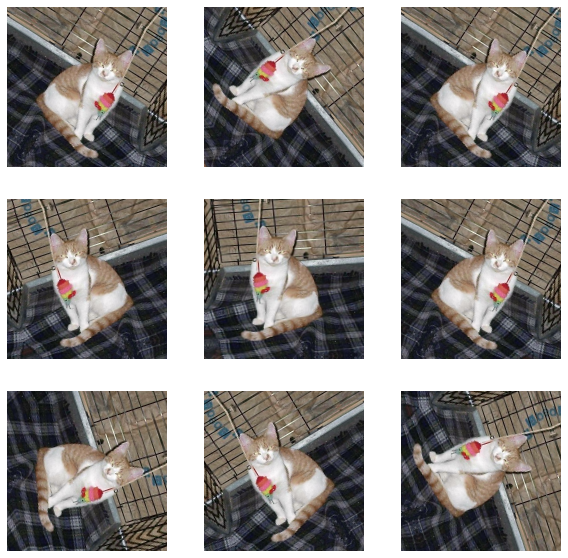

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### 2.4 Rescale pixel values

In a moment, you will download `tf.keras.applications.MobileNetV2` for use as your base model. This model expects pixel values in `[-1, 1]`, but at this point, the pixel values in your images are in `[0, 255]`. To rescale them, you can either use the preprocessing method included with the model like so:

`preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input`

Or you could rescale pixel values from `[0, 255]` to `[-1, 1]` using `tf.keras.layers.Rescaling`.

In [ ]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

Note: If using other `tf.keras.applications`, **be sure to check the API doc to determine if they expect pixels in `[-1, 1]` or `[0, 1]`**, or use the included `preprocess_input` function.

### 2.5 Create the base model from the pre-trained convnets
You will create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the [ImageNet](https://www.image-net.org/) dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like `jackfruit` and `syringe`. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,) # 3D shape in the format (height, width, channels)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


This feature extractor converts each `160x160x3` image into a `5x5x1280` block of features. Let's see what it does to an example batch of images:

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


### 2.6 Freeze the convolutional base

In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's `trainable` flag to False will freeze all of them.

In [ ]:
base_model.trainable = False

#### 2.6.1 Important note about BatchNormalization layers

Many models contain `tf.keras.layers.BatchNormalization` layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial. 

When you set `layer.trainable = False`, the `BatchNormalization` layer will run in inference mode, and will not update its mean and variance statistics. 

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing `training = False` when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

For more details, see the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

### 2.7 Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In TensorFlow, both `flatten()` and `GlobalAveragePooling2D()` are used to reshape the output of a layer, but they have different purposes and work in different ways.

`flatten()` is used to convert a multi-dimensional tensor (e.g., a 2D or 3D tensor) into a 1D tensor by concatenating all the elements along the dimensions. It is often used to connect a convolutional or pooling layer to a dense (fully connected) layer in a neural network. Imagine you have a 2D grid with numbers, and you want to line up all the numbers in a single row. That's what `flatten()` does.
For example, if you have a tensor with shape (batch_size, 2, 2, 3), after applying `flatten()`, it will become (batch_size, 12), as 2 * 2 * 3 = 12.

`GlobalAveragePooling2D()` is a type of pooling layer that calculates the average value of each feature map in a 2D tensor, reducing it to a single value per feature map. It is commonly used to reduce the spatial dimensions of the output from a convolutional layer before connecting it to a dense (fully connected) layer. This method helps to reduce the number of parameters and can prevent overfitting.
For example, if you have a tensor with shape (batch_size, 2, 2, 3), after applying `GlobalAveragePooling2D()`, it will become (batch_size, 3). It computes the average value of each 2x2 feature map, resulting in one value per feature map.

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Build a model by chaining together the data augmentation, rescaling, `base_model` and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, use `training=False` as our model contains a `BatchNormalization` layer.

In [ ]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(160, 160, 3)),
    data_augmentation,
    rescale,
    base_model,
    global_average_layer,
    tf.keras.layers.Dropout(0.2),
    prediction_layer
])

### 2.8 Compile the model

Compile the model before training it. Since there are two classes, use the `tf.keras.losses.BinaryCrossentropy` loss with `from_logits=True` since the model provides a linear output.

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 160, 160, 3)       0         
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1)                

The 2.5 million parameters in MobileNet are frozen, but there are 1.2 thousand _trainable_ parameters in the Dense layer. These are divided between two `tf.Variable` objects, the weights and biases.

In [ ]:
len(model.trainable_variables)

2

### 2.9 Train the model

After training for 10 epochs, you should see ~94% accuracy on the validation set.


In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 4s 43ms/step - loss: 0.7077 - accuracy: 0.5371


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.71
initial accuracy: 0.54


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10


63/63 [==============================] - 19s 182ms/step - loss: 0.6604 - accuracy: 0.6085 - val_loss: 0.4622 - val_accuracy: 0.7178
Epoch 2/10
63/63 [==============================] - 9s 145ms/step - loss: 0.4999 - accuracy: 0.7180 - val_loss: 0.3485 - val_accuracy: 0.8106
Epoch 3/10
63/63 [==============================] - 13s 208ms/step - loss: 0.4130 - accuracy: 0.7800 - val_loss: 0.2737 - val_accuracy: 0.8713
Epoch 4/10
63/63 [==============================] - 10s 162ms/step - loss: 0.3468 - accuracy: 0.8280 - val_loss: 0.2333 - val_accuracy: 0.8948
Epoch 5/10
63/63 [==============================] - 9s 146ms/step - loss: 0.2940 - accuracy: 0.8675 - val_loss: 0.1969 - val_accuracy: 0.9257
Epoch 6/10
63/63 [==============================] - 10s 158ms/step - loss: 0.2799 - accuracy: 0.8725 - val_loss: 0.1753 - val_accuracy: 0.9282
Epoch 7/10
63/63 [==============================] - 9s 140ms/step - loss: 0.2541 - accuracy: 0.8870 - val_loss: 0.1577 - val_accuracy: 0.9356
Epoch 8/10
63

### 2.10 Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNetV2 base model as a fixed feature extractor.

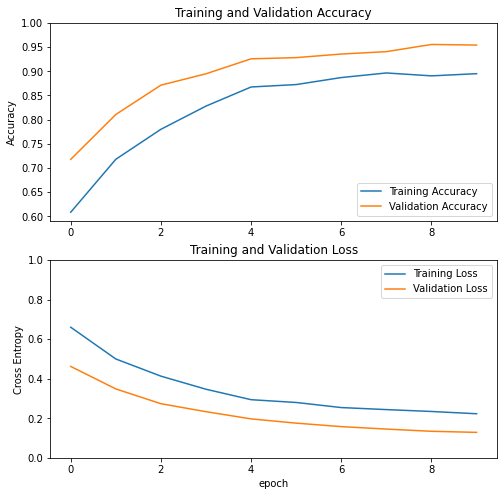

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like `tf.keras.layers.BatchNormalization` and `tf.keras.layers.Dropout` affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

## 3 Fine tuning
In the feature extraction experiment, you were only training a few layers on top of an MobileNetV2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

**Note:** This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

### 3.1 Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  154


### 3.2 Compile the model

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 160, 160, 3)       0         
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1)                

In [ ]:
len(model.trainable_variables)

56

### 3.3 Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20


63/63 [==============================] - 23s 169ms/step - loss: 0.3974 - accuracy: 0.8385 - val_loss: 0.0950 - val_accuracy: 0.9740
Epoch 11/20
63/63 [==============================] - 11s 175ms/step - loss: 0.2849 - accuracy: 0.8865 - val_loss: 0.0851 - val_accuracy: 0.9728
Epoch 12/20
63/63 [==============================] - 10s 155ms/step - loss: 0.2223 - accuracy: 0.9080 - val_loss: 0.0682 - val_accuracy: 0.9790
Epoch 13/20
63/63 [==============================] - 10s 153ms/step - loss: 0.2000 - accuracy: 0.9220 - val_loss: 0.0558 - val_accuracy: 0.9814
Epoch 14/20
63/63 [==============================] - 14s 227ms/step - loss: 0.1653 - accuracy: 0.9335 - val_loss: 0.0516 - val_accuracy: 0.9814
Epoch 15/20
63/63 [==============================] - 13s 197ms/step - loss: 0.1574 - accuracy: 0.9305 - val_loss: 0.0536 - val_accuracy: 0.9777
Epoch 16/20
63/63 [==============================] - 12s 192ms/step - loss: 0.1445 - accuracy: 0.9360 - val_loss: 0.0499 - val_accuracy: 0.9827
Epoc

Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNetV2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNetV2 datasets.


After fine tuning the model nearly reaches 98% accuracy on the validation set.

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

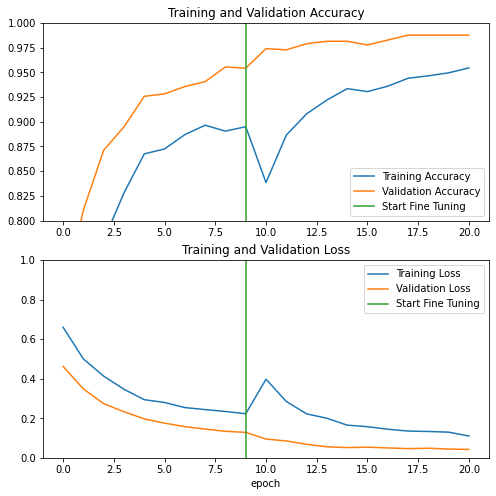

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### 3.4 Evaluation and prediction

Finally you can verify the performance of the model on new data using test set.

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 1s 48ms/step - loss: 0.0342 - accuracy: 0.9896
Test accuracy : 0.9895833134651184


And now you are all set to use this model to predict if your pet is a cat or dog.

Predictions:
 [1 1 0 0 0 0 1 1 1 0 1 0 0 0 0 1 0 0 1 0 0 0 1 1 1 1 0 1 1 1 0 1]
Labels:
 [1 1 0 0 0 0 1 1 1 0 1 0 0 0 0 1 0 0 1 0 0 0 1 1 1 1 0 1 1 1 0 1]


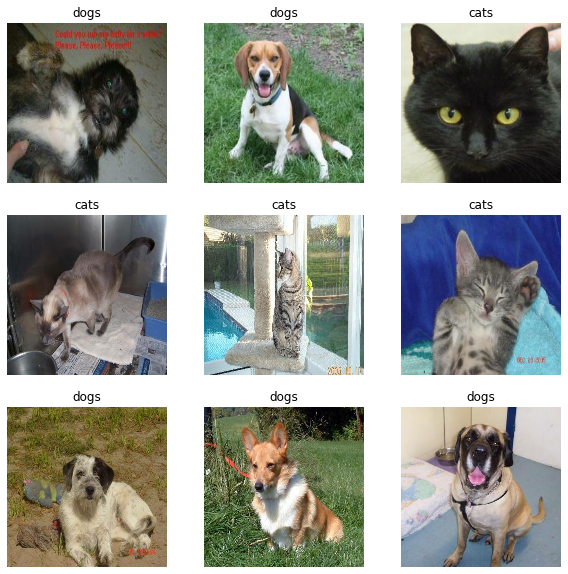

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## 4 Summary

* **Using a pre-trained model for feature extraction**:  When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training.
In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

* **Fine-tuning a pre-trained model**: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning.
In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.

To learn more, visit the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).


## 5 Exercises

In the previous notebooks, you worked with the flowers dataset. You saw that a straightforward CNN model trained from scratch on this dataset would tend to overfit, and that techniques such as regularization, dropout, and data augmentation helped prevent overfitting to some extent. However, your validation accuracy on this dataset was probably not higher than 80% or so.

Your goal in this exercise is to leverage the power of transfer learning on the flowers dataset. There are several pre-trained models to choose from, and I would recommend a model from the ResNet or VGG family for this task. What is the maximum possible validation accuracy you can achieve with transfer learning on this dataset?

In [ ]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Download dataset

import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

# Load data using Keras dataloader
batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names

# Configure dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


Load a pre-trained model using Keras applications (or if you prefer, from the TensorFlow hub). Freeze the model, remove the classification layers, and train the model on this dataset. If you wish, you can then unfreeze the model and fine-tune it.

In [ ]:
# Your code here

# This is a potential solution using the ResNet50 model
# Note that by default ResNet50 expects images with shape 224x224x3 so I have put that in the dataloader
# If you use a different model, see what the expected input shape is and modify accordingly


# Downloading the ResNet50 model
resnet50_model = tf.keras.applications.resnet50.ResNet50(input_shape=(img_height, img_width, 3),
                                               include_top=False,
                                               weights='imagenet')


94765736/94765736 [==============================] - 1s 0us/step


First, I will freeze this model (make it untrainable), add a trainable dense layer, and train it on the flowers dataset.

In [ ]:
# Freezing the model
resnet50_model.trainable = False

# A layer to globally average features and give a 1D output for the dense layers
global_average_layer = layers.GlobalAveragePooling2D()

# An output layer with the predictions
num_classes = len(class_names)
prediction_layer = layers.Dense(num_classes)

# I will add a bit of data augmentation
data_augmentation = Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
])

# First, prepare the required preprocessing for the ResNet50 model:
preprocess_input = tf.keras.applications.resnet50.preprocess_input

# This is a function. To convert this into a layer, use the Keras Lambda layer.
# Alternatively, use the functional method of building a neural network and apply this function.
# Alternatively, see what the preprocessing does, and try to emulate it with Keras layers.

preprocessing_layer = layers.Lambda(preprocess_input)

In [ ]:
# Build the model

transfer_model = tf.keras.Sequential([
    tf.keras.Input(shape=(img_height, img_width, 3)),
    data_augmentation,
    preprocessing_layer,
    resnet50_model,
    global_average_layer,
    layers.Dropout(0.2),
    prediction_layer
])

In [ ]:
# Compile the model

base_learning_rate = 0.0001
transfer_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# Fit the model

initial_epochs = 10

# Add early stopping to the tuning process
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history = transfer_model.fit(train_ds, validation_data=val_ds, epochs=initial_epochs, callbacks=[stop_early])

Epoch 1/10


92/92 [==============================] - 39s 217ms/step - loss: 1.6321 - accuracy: 0.3525 - val_loss: 1.1247 - val_accuracy: 0.5722
Epoch 2/10
92/92 [==============================] - 17s 190ms/step - loss: 1.0516 - accuracy: 0.5896 - val_loss: 0.8010 - val_accuracy: 0.7289
Epoch 3/10
92/92 [==============================] - 18s 191ms/step - loss: 0.7916 - accuracy: 0.7139 - val_loss: 0.6434 - val_accuracy: 0.8011
Epoch 4/10
92/92 [==============================] - 18s 196ms/step - loss: 0.6682 - accuracy: 0.7667 - val_loss: 0.5605 - val_accuracy: 0.8324
Epoch 5/10
92/92 [==============================] - 18s 196ms/step - loss: 0.5911 - accuracy: 0.7902 - val_loss: 0.5009 - val_accuracy: 0.8460
Epoch 6/10
92/92 [==============================] - 18s 200ms/step - loss: 0.5229 - accuracy: 0.8222 - val_loss: 0.4605 - val_accuracy: 0.8569
Epoch 7/10
92/92 [==============================] - 18s 191ms/step - loss: 0.4778 - accuracy: 0.8362 - val_loss: 0.4310 - val_accuracy: 0.8624
Epoch 8/10

I got roughly 87% validation accuracy. I will try to increase this by unfreezing some of the feature-extraction layers and fine-tuning more of the model on my dataset.

In [ ]:
# First, unfreeze the whole feature-extraction model
resnet50_model.trainable = True

In [ ]:
# Check to see how many layers there are
print("Number of layers in the base model: ", len(resnet50_model.layers))

Number of layers in the base model:  175


In [ ]:
# I will freeze the first 80 layers.
# You can experiment with this to see if freezing more/fewer layers helps

# Fine-tune from this layer onwards
fine_tune_at = 80

# Freeze all the layers before the `fine_tune_at` layer
for layer in resnet50_model.layers[:fine_tune_at]:
    layer.trainable = False

In [ ]:
# Compile the model

transfer_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = transfer_model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds,
                         callbacks=[stop_early])

Epoch 10/20


92/92 [==============================] - 50s 296ms/step - loss: 0.4355 - accuracy: 0.8481 - val_loss: 0.2923 - val_accuracy: 0.8842
Epoch 11/20
92/92 [==============================] - 26s 284ms/step - loss: 0.2812 - accuracy: 0.9026 - val_loss: 0.2378 - val_accuracy: 0.9114
Epoch 12/20
92/92 [==============================] - 27s 289ms/step - loss: 0.2180 - accuracy: 0.9261 - val_loss: 0.2150 - val_accuracy: 0.9210
Epoch 13/20
92/92 [==============================] - 26s 283ms/step - loss: 0.1664 - accuracy: 0.9469 - val_loss: 0.1979 - val_accuracy: 0.9278
Epoch 14/20
92/92 [==============================] - 26s 283ms/step - loss: 0.1354 - accuracy: 0.9574 - val_loss: 0.1845 - val_accuracy: 0.9305
Epoch 15/20
92/92 [==============================] - 26s 281ms/step - loss: 0.0998 - accuracy: 0.9762 - val_loss: 0.1776 - val_accuracy: 0.9346
Epoch 16/20
92/92 [==============================] - 26s 282ms/step - loss: 0.0771 - accuracy: 0.9775 - val_loss: 0.1676 - val_accuracy: 0.9346
Epoc

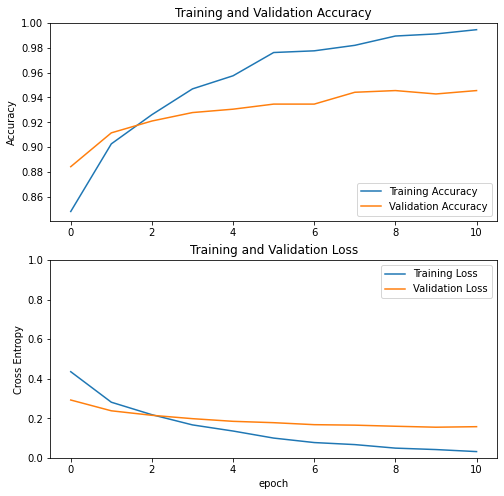

In [ ]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()